In [74]:
## Run generate_data notebook first before running this to generate the data.
import numpy as np

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd.variable import Variable
import copy
import h5py
import h5utils
import time
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

In [2]:
## Change act_func, dropout value and update the model class accordingly and run the notebook to generate results

## configs
act_func = 'ReLU'
###########################

## Hyper Params
LR = 0.01
MAX_EPOCH = 500
BATCH_SIZE = 64
###########################


## NN Model
############################
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(1, 100, bias=True),
                                       nn.ReLU(),  ## update act_func
                                       nn.Linear(100, 200, bias=True),
                                       nn.ReLU(),  ## update act_func
                                       nn.Linear(200, 1))
    def forward(self, x):
        output = self.regressor(x)
        return output

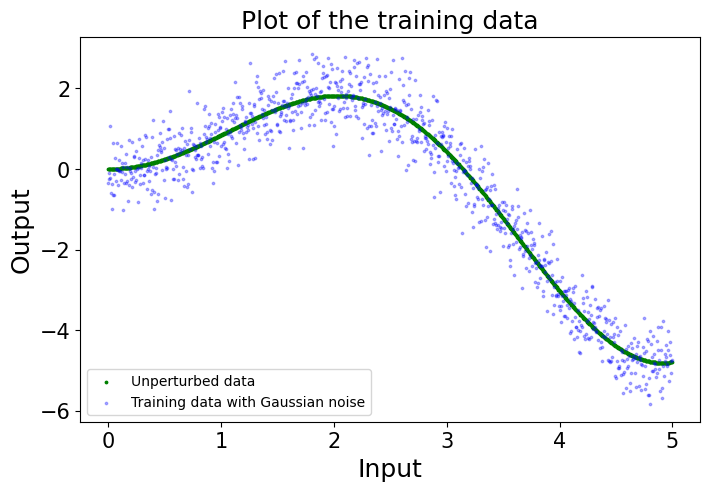

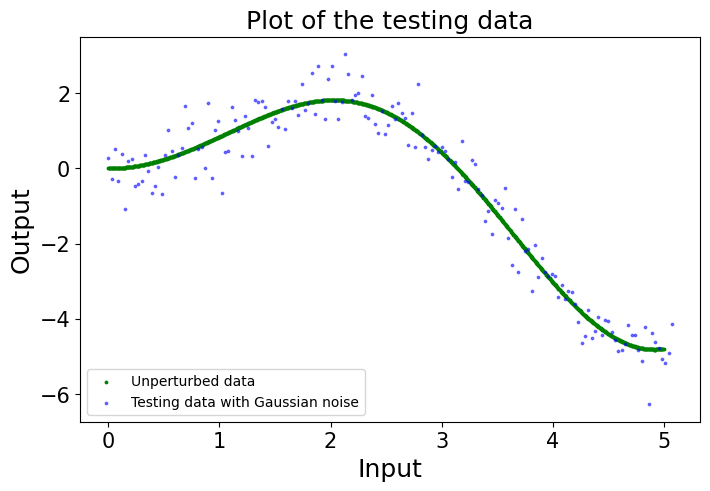

In [3]:
## Load the data files 
case_type = 1

X_train = X_train_og = np.loadtxt('data/X_train_1.txt')
X_test = X_test_og = np.loadtxt('data/X_test_1.txt')

y = np.loadtxt('data/y_unpurt_1.txt')
y_train = y_train_og = np.loadtxt('data/y_train_1.txt')
y_test = y_test_og = np.loadtxt('data/y_test_1.txt')


## Just subsetting the data to make the data simple: no other reason
X_train = X_train[0:1000]
y_train = y_train[0:1000]
y = y[0:1000]
X_test = X_test[0:170]
y_test = y_test[0:170]


## plot train data
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.set_title('Plot of the training data',fontsize=18)
ax.scatter(X_train,y,s=3,c='g',label='Unperturbed data')
plt.scatter(X_train,y_train,s=3,c='b',alpha=0.3,label='Training data with Gaussian noise')
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Output',fontsize=18)
ax.legend(loc='lower left')

## plot test data
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.set_title('Plot of the testing data',fontsize=18)
ax.scatter(X_train,y,s=3,c='g',label='Unperturbed data')
plt.scatter(X_test,y_test,s=3,c='b',alpha=0.5,label='Testing data with Gaussian noise')
ax.set_xlabel('Input',fontsize=18)
ax.set_ylabel('Output',fontsize=18)
ax.legend(loc='lower left')


## Convert to Torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [4]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
# print(device)
train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_test.unsqueeze(1), y_test.unsqueeze(1)), batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=True)

X_test = torch.reshape(X_test,(X_test.size()[0],1))
X_test = X_test.type(torch.float32)

print(X_test.size())

torch.Size([170, 1])


In [5]:
model = Regressor().to(device)

model_init = model

print(model)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

# ## access initial weights
# with torch.no_grad():
#     for param in model.parameters():
#         print(param.detach().shape)

# training loop
train_loss_list = list()
val_loss_list = list()
predictions = []
for epoch in range(MAX_EPOCH):
    model.train()
    
    # training loop
    temp_loss_list = list()
    for X_train, y_train in train_dataloader:
        X_train = X_train.type(torch.float32).to(device)
        y_train = y_train.type(torch.float32).to(device)

        optimizer.zero_grad()

        score = model(X_train)
        loss = criterion(score,y_train)
        loss.backward()
        optimizer.step()

        temp_loss_list.append(loss.detach().cpu().numpy())

    train_loss_list.append(np.average(temp_loss_list))
   
    if epoch%100==0 or epoch==MAX_EPOCH-1:
        print("epoch: ",epoch," train loss: ", train_loss_list[-1])
                
# ######## plot loss values
# plt.plot(train_loss_list)

Regressor(
  (regressor): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)
epoch:  0  train loss:  2.169356
epoch:  100  train loss:  0.26941139
epoch:  200  train loss:  0.26180702
epoch:  300  train loss:  0.25750062
epoch:  400  train loss:  0.2903574
epoch:  499  train loss:  0.26905054


In [6]:
## create a copy of the trained model. this should be initial state of the model
model.eval()
model_init.eval()


# test_sample_id=100
# predicted = model(X_test[test_sample_id])
# loss = criterion(predicted,y_test[test_sample_id])
# print(loss.detach())


# ## access weights before modifying
# with torch.no_grad():
#     for param in model.parameters():
#         print(param.detach())

# ## dummy function that addes 1 with each weight value
# def f(t):
#     return t + 1


# params = [f(p) for p in model1.parameters()]


# with torch.no_grad():
#     params = [p.copy_(q) for (p, q) in zip(model1.parameters(), params)]
    
    
# ## access weights after modifying
# with torch.no_grad():
#     for param in model1.parameters():
#         print(param.detach())

Regressor(
  (regressor): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)

##  All functions obtained from the repository

In [120]:
def get_weights(net):
    """ Extract parameters from net, and return a list of tensors"""
    return [p.data for p in net.parameters()]

def get_random_weights(weights):
    """
        Produce a random direction that is a list of random Gaussian tensors
        with the same shape as the network's weights, so one direction entry per weight.
    """
    return [torch.randn(w.size()) for w in weights]

def create_random_direction(net, dir_type='weights', ignore='biasbn', norm='filter'):
    """
        Setup a random (normalized) direction with the same dimension as
        the weights or states.

        Args:
          net: the given trained model
          dir_type: 'weights' or 'states', type of directions.
          ignore: 'biasbn', ignore biases and BN parameters.
          norm: direction normalization method, including
                'filter" | 'layer' | 'weight' | 'dlayer' | 'dfilter'

        Returns:
          direction: a random direction with the same dimension as weights or states.
    """

    # random direction
    if dir_type == 'weights':
        weights = get_weights(net) # a list of parameters.
        direction = get_random_weights(weights)
        direction = [tensor.to(device) for tensor in direction]

        for i, tensor in enumerate(direction):
            print(f"Tensor {i} is on {tensor.device} device")
        normalize_directions_for_weights(direction, weights, norm, ignore)
    elif dir_type == 'states':
        states = net.state_dict() # a dict of parameters, including BN's running mean/var.
        direction = get_random_states(states)
        normalize_directions_for_states(direction, states, norm, ignore)

    return direction


def normalize_directions_for_weights(direction, weights, norm='filter', ignore='biasbn'):
    """
        The normalization scales the direction entries according to the entries of weights.
    """
    assert(len(direction) == len(weights))
    for d, w in zip(direction, weights):
        if d.dim() <= 1:
            if ignore == 'biasbn':
                d.fill_(0) # ignore directions for weights with 1 dimension
            else:
                d.copy_(w) # keep directions for weights/bias that are only 1 per node
        else:
            normalize_direction(d, w, norm)
            
def normalize_direction(direction, weights, norm='filter'):
    """
        Rescale the direction so that it has similar norm as their corresponding
        model in different levels.

        Args:
          direction: a variables of the random direction for one layer
          weights: a variable of the original model for one layer
          norm: normalization method, 'filter' | 'layer' | 'weight'
    """
    if norm == 'filter':
        # Rescale the filters (weights in group) in 'direction' so that each
        # filter has the same norm as its corresponding filter in 'weights'.
        for d, w in zip(direction, weights):
            d.mul_(w.norm()/(d.norm() + 1e-10))
    elif norm == 'layer':
        # Rescale the layer variables in the direction so that each layer has
        # the same norm as the layer variables in weights.
        direction.mul_(weights.norm()/direction.norm())
    elif norm == 'weight':
        # Rescale the entries in the direction so that each entry has the same
        # scale as the corresponding weight.
        direction.mul_(weights)
    elif norm == 'dfilter':
        # Rescale the entries in the direction so that each filter direction
        # has the unit norm.
        for d in direction:
            d.div_(d.norm() + 1e-10)
    elif norm == 'dlayer':
        # Rescale the entries in the direction so that each layer direction has
        # the unit norm.
        direction.div_(direction.norm())
        
def write_list(f, name, direction):
    """ Save the direction to the hdf5 file with name as the key

        Args:
            f: h5py file object
            name: key name_surface_file
            direction: a list of tensors
    """

    grp = f.create_group(name)
    for i, l in enumerate(direction):
        if isinstance(l, torch.Tensor):
            l = l.numpy()
        grp.create_dataset(str(i), data=l)


def read_list(f, name):
    """ Read group with name as the key from the hdf5 file and return a list numpy vectors. """
    grp = f[name]
    return [grp[str(i)] for i in range(len(grp))]

## adapted from setup_surface_file()
def gen_surface_file(surf_file, dir_file):
    
    f = h5py.File(surf_file, 'a')
    f['dir_file'] = dir_file

    # Create the coordinates(resolutions) at which the function is evaluated
    xcoordinates = np.linspace(-1.0, 1.0, num=50)
    f['xcoordinates'] = xcoordinates
    f.close()

    return surf_file

def load_directions(dir_file):
    """ Load direction(s) from the direction file."""

    f = h5py.File(dir_file, 'r')
    if 'ydirection' in f.keys():  # If this is a 2D plot
        xdirection = read_list(f, 'xdirection')
        ydirection = read_list(f, 'ydirection')
        directions = [xdirection, ydirection]
    else:
        directions = [read_list(f, 'xdirection')]

    return directions

def get_job_indices(vals, xcoordinates, ycoordinates):
    """
    Prepare the job indices over which coordinate to calculate.

    Args:
        vals: the value matrix
        xcoordinates: x locations, i.e.,[-1, -0.5, 0, 0.5, 1]
        ycoordinates: y locations, i.e.,[-1, -0.5, 0, 0.5, 1]
        comm: MPI environment

    Returns:
        inds: indices that splitted for current rank
        coords: coordinates for current rank
        inds_nums: max number of indices for all ranks
    """

    inds, coords = get_unplotted_indices(vals, xcoordinates, ycoordinates)

    rank = 0 
    nproc = 1
    splitted_idx = split_inds(len(inds), nproc)

    # Split the indices over the available MPI processes
    inds = inds[splitted_idx[rank]]
    coords = coords[splitted_idx[rank]]

    # Figure out the number of jobs that each MPI process needs to calculate.
    inds_nums = [len(idx) for idx in splitted_idx]

    return inds, coords, inds_nums



def get_unplotted_indices(vals, xcoordinates, ycoordinates=None):
    """
    Args:
      vals: values at (x, y), with value -1 when the value is not yet calculated.
      xcoordinates: x locations, i.e.,[-1, -0.5, 0, 0.5, 1]
      ycoordinates: y locations, i.e.,[-1, -0.5, 0, 0.5, 1]

    Returns:
      - a list of indices into vals for points that have not yet been calculated.
      - a list of corresponding coordinates, with one x/y coordinate per row.
    """

    # Create a list of indices into the vectorizes vals
    inds = np.array(range(vals.size))

    # Select the indices of the un-recorded entries, assuming un-recorded entries
    # will be smaller than zero. In case some vals (other than loss values) are
    # negative and those indexces will be selected again and calcualted over and over.
    inds = inds[vals.ravel() <= 0]

    # Make lists containing the x- and y-coodinates of the points to be plotted
    if ycoordinates is not None:
        # If the plot is 2D, then use meshgrid to enumerate all coordinates in the 2D mesh
        xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
        s1 = xcoord_mesh.ravel()[inds]
        s2 = ycoord_mesh.ravel()[inds]
        return inds, np.c_[s1,s2]
    else:
        return inds, xcoordinates.ravel()[inds]
    
def split_inds(num_inds, nproc):
    """
    Evenly slice out a set of jobs that are handled by each MPI process.
      - Assuming each job takes the same amount of time.
      - Each process handles an (approx) equal size slice of jobs.
      - If the number of processes is larger than rows to divide up, then some
        high-rank processes will receive an empty slice rows, e.g., there will be
        3, 2, 2, 2 jobs assigned to rank0, rank1, rank2, rank3 given 9 jobs with 4
        MPI processes.
    """

    chunk = num_inds // nproc
    remainder = num_inds % nproc
    splitted_idx = []
    for rank in range(0, nproc):
        # Set the starting index for this slice
        start_idx = rank * chunk + min(rank, remainder)
        # The stopping index can't go beyond the end of the array
        stop_idx = start_idx + chunk + (rank < remainder)
        splitted_idx.append(range(start_idx, stop_idx))

    return splitted_idx

def set_weights(net, weights, directions=None, step=None):
    """
        Overwrite the network's weights with a specified list of tensors
        or change weights along directions with a step size.
    """
    if directions is None:
        # You cannot specify a step length without a direction.
        for (p, w) in zip(net.parameters(), weights):
            p.data.copy_(w.type(type(p.data)))
    else:
        assert step is not None, 'If a direction is specified then step must be specified as well'

        if len(directions) == 2:
            dx = directions[0]
            dy = directions[1]
            changes = [d0*step[0] + d1*step[1] for (d0, d1) in zip(dx, dy)]
        else:
            changes = [d*step for d in directions[0]]
        
#         print(len(changes))

        for (p, w, d) in zip(net.parameters(), weights, changes):
            p.data = w + torch.Tensor(d).type(type(w))

            
import torch
from torch.autograd import Variable

def eval_loss(net, criterion, loader, use_cuda=False):
    """
    Evaluate the loss value for a given 'net' on the dataset provided by the loader in a regression context.

    Args:
        net: the neural net model
        criterion: loss function, expected to be an instance of nn.MSELoss
        loader: dataloader
        use_cuda: use cuda or not
    Returns:
        Average loss value over the dataset
    """
    total_loss = 0
    total = 0 # number of samples

    if use_cuda:
        net.cuda()
    net.eval()

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            batch_size = inputs.size(0)
            total += batch_size
            inputs, targets = Variable(inputs.float()), Variable(targets.float())
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()*batch_size

    average_loss = total_loss / total
    return average_loss
         
            
            
def crunch(surf_file, net, w, s, d, dataloader, loss_key, acc_key):
    f = h5py.File(surf_file, 'r+')
    losses, accuracies = [], []
    xcoordinates = f['xcoordinates'][:]
    ycoordinates = f['ycoordinates'][:] if 'ycoordinates' in f.keys() else None

    if loss_key not in f.keys():
        shape = xcoordinates.shape if ycoordinates is None else (len(xcoordinates),len(ycoordinates))
        losses = -np.ones(shape=shape)
        accuracies = -np.ones(shape=shape)
        f[loss_key] = losses
        f[acc_key] = accuracies
    else:
        losses = f[loss_key][:]
        accuracies = f[acc_key][:]
        
    # Generate a list of indices of 'losses' that need to be filled in.
    # The coordinates of each unfilled index (with respect to the direction vectors
    # stored in 'd') are stored in 'coords'.
    inds, coords, inds_nums = get_job_indices(losses, xcoordinates, ycoordinates)
    start_time = time.time()
   
    print('Computing', len(inds), 'values')
#     print((inds))
    criterion = nn.MSELoss()
    
    
    # Loop over all uncalculated loss values
    for count, ind in enumerate(inds):
        # Get the coordinates of the loss value being calculated
        coord = coords[count]
#         print(coords)
        
        #Load the weights corresponding to those coordinates into the net
        set_weights(model, w, d, coord)
        
        # Record the time to compute the loss value        
        loss_start = time.time()
        loss = eval_loss(model, criterion, dataloader, False)
        loss_compute_time = time.time() - loss_start
        
        # Record the result in the local array
        losses.ravel()[ind] = loss


        # Only the master node writes to the file - this avoids write conflicts
        f[loss_key][:] = losses


        f.flush()

        print('Evaluating \t%s= %.3f \ttime=%.2f' % (loss_key, loss, loss_compute_time))
        
    total_time = time.time() - start_time
    print('Total time: %.2f' % total_time)

        # Assuming 'f' is an open file or h5py.File object for writing results
    f.close()
        


In [121]:
import os

file_path = 'dir_file.h5'  # Replace with your file path
# Check if file exists
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File {file_path} has been deleted.")
else:
    print(f"The file {file_path} does not exist.")

file_path2 = 'surf_file.h5'  # Replace with your file path
# Check if file exists
if os.path.exists(file_path2):
    os.remove(file_path2)
    print(f"File {file_path2} has been deleted.")
else:
    print(f"The file {file_path2} does not exist.")



File dir_file.h5 has been deleted.
File surf_file.h5 has been deleted.


In [122]:
w = get_weights(model)
s = copy.deepcopy(model.state_dict()) # deepcopy since state_dict are references


dir_file = 'dir_file.h5'
surf_file = 'surf_file.h5'

xdirection = create_random_direction(model, 'weights', '', 'layer') ## last param should be layer or filter for a MLP?
# print((xdirection[1]))

f = h5py.File(dir_file,'w') # create file, fail if exists
write_list(f, 'xdirection', xdirection)
f.close()
print ("direction file created: %s" % dir_file)

gen_surface_file(surf_file, dir_file)
print ("surface file created: %s" % surf_file)

d = load_directions(dir_file)
print(len(d))

Tensor 0 is on cpu device
Tensor 1 is on cpu device
Tensor 2 is on cpu device
Tensor 3 is on cpu device
Tensor 4 is on cpu device
Tensor 5 is on cpu device
direction file created: dir_file.h5
surface file created: surf_file.h5
1


In [123]:
with h5py.File('surf_file.h5', 'r') as f:
    # Get the keys (group or dataset names) in the file
    keys = list(f.keys())
    print("Keys in the HDF5 file:", keys)


Keys in the HDF5 file: ['dir_file', 'xcoordinates']


In [124]:
crunch(surf_file, model, w, s, d, train_dataloader, 'train_loss', 'train_acc')

Computing 50 values
Evaluating 	train_loss= 19237563.536 	time=0.01
Evaluating 	train_loss= 17737112.704 	time=0.01
Evaluating 	train_loss= 16333034.960 	time=0.01
Evaluating 	train_loss= 15295580.336 	time=0.01
Evaluating 	train_loss= 14624817.432 	time=0.01
Evaluating 	train_loss= 14458519.072 	time=0.01
Evaluating 	train_loss= 14260507.248 	time=0.01
Evaluating 	train_loss= 13863257.840 	time=0.01
Evaluating 	train_loss= 13360126.920 	time=0.01
Evaluating 	train_loss= 12870327.808 	time=0.01
Evaluating 	train_loss= 12600373.680 	time=0.01
Evaluating 	train_loss= 12227072.824 	time=0.01
Evaluating 	train_loss= 11784904.144 	time=0.01
Evaluating 	train_loss= 11126608.496 	time=0.01
Evaluating 	train_loss= 10390432.728 	time=0.01
Evaluating 	train_loss= 9495080.616 	time=0.01
Evaluating 	train_loss= 8850751.200 	time=0.01
Evaluating 	train_loss= 8146704.700 	time=0.01
Evaluating 	train_loss= 7300546.196 	time=0.01
Evaluating 	train_loss= 6607596.904 	time=0.01
Evaluating 	train_loss= 5